In [108]:
# Common imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

In [109]:
import os
import urllib
import shutil

def download_file(url, dir_path="data"):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        
    file_name = os.path.split(url)[-1]
    file_path = os.path.join(dir_path, file_name)
    
    with urllib.request.urlopen(url) as response, open(file_path, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
        
    return file_path

In [4]:
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

## Трансформация данных (feature selection & feature extraction)

Для повышения качества работы ML моделей можно использовать только часть доступных атрибутов. Процедура выбора наиболее значимых атрибутов называется feature selection. 

Атрибуты можно комбинировать друг с другом. Предположим, что количество выпускаемых на заводе деталей зависит от количества сотрудников и количества конвейеров. В идеале, чем больше сотрудников и конвейеров, тем больше деталей производится. Если мы добавим конвейер, но не добавим на него людей, то никакой пользы от добавления конвейера не будет. Следовательно, в модель нужно добавить атрибут, учитывающий связь между сотрудниками и конвейерами. Поиск комбинаций атрибутов на основе знаний о природе исходных данных называется feature engineering.

# Рекламный бюджет

In [110]:
download_file("http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv")
adv_df = pd.read_csv('data/Advertising.csv', usecols=[1,2,3,4])
adv_df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [6]:
adv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
radio        200 non-null float64
newspaper    200 non-null float64
sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.3 KB


Выше представлены данные о продажах некоторого продукта (sales, в тысячах штук) в зависимости от рекламного бюджета (в тысячах долларов), потраченного на различные медиа (TV, Radio и Newspapers). Предположим, что вы консультант, которого попросили создать маркетинговый план на следующий год на основе этих данных, так, чтобы продажи продукта были высокими.

 ## Что мы пытаемся понять?

1. Есть ли связь между рекламным бюджетом и продажами?
2. Насколько сильна связь между бюджетом и продажами? Можем ли мы предсказывать продажи на основе бюджета?
3. Какие медиа способствуют продажам?
4. Насколько точно мы можем предсказывать будущие продажи?
6. Линейная ли зависимость между бюджетом и продажами?
7. Есть ли эффект взаимодействия (synergy/interaction effect) между медийными бюджетами?

Мы ответим на эти вопросы, используя только линейную регрессию.

## Выбор модели

In [38]:
from sklearn.linear_model import LinearRegression
import math

In [123]:
adv_df['log_tv'] = adv_df.TV.apply(lambda x: math.log(x, 2))

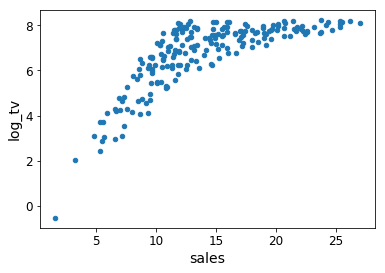

In [124]:
adv_df.plot.scatter('sales', 'log_tv')

In [125]:
adv_df['log_tv'] = adv_df.TV.apply(lambda x: math.pow(x, 0.4))

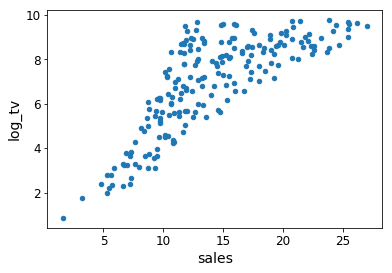

In [126]:
adv_df.plot.scatter('sales', 'log_tv')

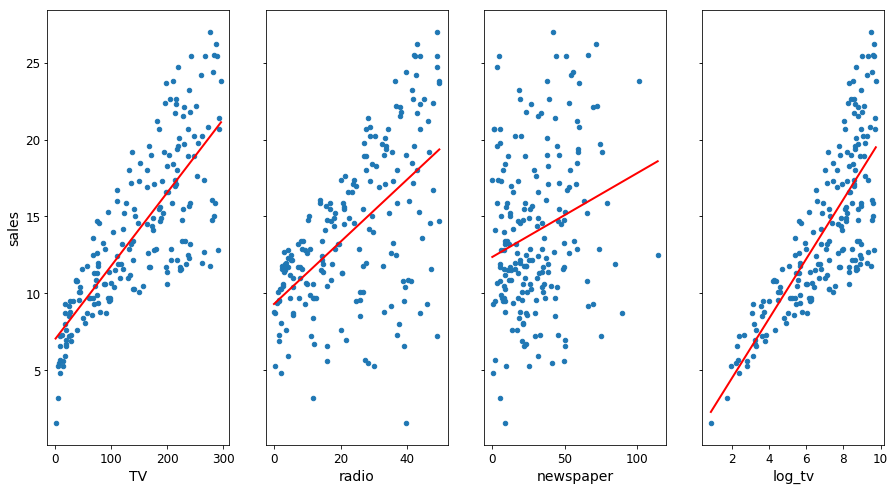

In [127]:
%matplotlib inline


fig.suptitle('Зависимость от компонент', fontsize=20)
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(15,8))
y_col = 'sales'


for i, x_col in enumerate(adv_df.columns.drop(y_col)):
    adv_df.plot.scatter(x_col, y_col, ax=axes[i])
    
    lm = LinearRegression().fit(
        adv_df[x_col].values.reshape(-1, 1), 
        adv_df[y_col].values.reshape(-1, 1)
    )
    xs = np.array([adv_df[x_col].min(), adv_df[x_col].max()]).reshape(-1, 1)
    ys = lm.predict(xs)
    axes[i].plot(xs, ys, c='r', linewidth=2)

У нас есть 3 атрибута и мы считаем, что все они полезные. Так как мы используем линейную регрессию, модель будет выглядеть следующим образом:
$$sales = \beta_0 + \beta_1 * TV + \beta_2 * Radio + \beta_3 * Newspaper$$

На данный момент мы опустим тот факт, что медийные бюджеты в нашей модели не влияют друг на друга.

## t-statistcs,  p-value, $R^2$, RSE, F-statistics

Итак, у нас есть линейная модель и мы можем посчитать коэффициенты $\beta_0, \beta_1, \beta_2, \beta_3$. Найдем их (и немного статической информации о работе модели), воспользовавшись библиотечкой statsmodel.

In [128]:
est = smf.ols('sales ~ TV + radio + newspaper', data=adv_df).fit()
est_res = est.summary()
est_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
radio,0.1885,0.009,21.893,0.000,0.172,0.206
newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011


### Standard error

Как мы помним, настоящее линейное представление данных выглядит как:
$$y = \beta_0 + \beta_1 * x_1 + \beta_2 * x_2 + \dots + \beta_n * x_n + \epsilon$$

где $\epsilon$ - неприводимая ошибка (irreducible error). Поэтому наша модель это аппроксимация вида:
$$\hat{y} = \beta_0 + \beta_1 * x_1 + \beta_2 * x_2 + \dots + \beta_n * x_n$$

Более того, так как мы работаем лишь с сэмплом данных (а не с полным набором), то коэффициенты $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ на самом деле тоже аппроксимация ($\hat{\beta_0}, \hat{\beta_1}, \hat{\beta_2}, \dots, \hat{\beta_n}$). И, конечно, нам интересно знать, насколько она точна. Для этих целей используется *стандартная ошибка*.

Стандартную ошибку можно посчитать для каждого параметра (мы опустим особенности и ограничения этих вычислений). Зная стандартные ошибки, можно вычислить доверительные интервалы. Например, $95\%$ значений $\beta_0$ будут в интервале $[2.324, 3.554]$ (т.е., без какой-либо рекламы с 95% уверенностью мы сможем продавать от $2324$ до $3554$ единиц товара).

### Проверка гипотезы (t-statistics и p-value)

Используя стандартные ошибки, мы можем проверять гипотезы. Наиболее популярный тип проверки - сопоставление *нулевой* и *альтернативной гипотезы*:

$H_0$: между $x_i$ и $y$ нет зависимости

$H_a$: между $x_i$ и $y$ есть зависимость

В нашем случае, математически это выглядит так:
$$
H_0: \beta_i = 0 \\
H_a: \beta_i \ne 0
$$

Для проверки этой гипотезы производится t-тест:
$$t = \frac{\hat{\beta_i} - 0}{SE(\hat{\beta_i})}$$
SE - standard error.

Если между $x_i$ и $y$ нет зависимости, то мы ожидаем, что $t$ будет соответствовать $t$-распределению с $n-2$ степенями свободы ($n$ - количество экземпляров в сэмпле). Таким образом, чтобы подтвердить $H_0$ при известном распределении, нам достаточно найти вероятность того, что наблюдаемое значение $\ge |t|$ при условии, что $\beta_i = 0$. Данная вероятность называется $p$-value.

Если $p$-value достаточно маленький (обычно меньше $1\%$), то мы можем отклонить нулевую гипотезу. 

In [129]:
est_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
radio,0.1885,0.009,21.893,0.000,0.172,0.206
newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011


В нашем случае все медиа, кроме Newspapers, имеют маленький $p$-value. Т.е. между Newspaper и Sales нет линейной зависимости и, следовательно, этого атрибута можно избавиться.

Недостатком определения полезности атрибутов с использованием t-statistics является то, что оценка важности каждого атрибута производится независимо от других, что может быть ошибочно.

### $R^2$

Линейная регрессия минимизирует метрику RSS (residual sum of squares), которая равна сумме квадратов наблюдаемых ошибок:
$$RSS = \sum_{i = 1}^n(y_i - \hat{y_i})^2$$

К сожалению, данная величина абсолютная и по ней сложно определить качество модели. Поэтому качество линейной регрессии часто оценивают при помощи двух других метрик: RSE (residual standard error) и $R^2$.
$$RSE = \sqrt{\frac{1}{n-p-1}RSS}$$

$$R^2 = \frac{TSS - RSS}{TSS} = 1 - \frac{RSS}{TSS}, \quad TSS = \sum_{i = 1}^n(y_i - \bar{y})^2$$

$TSS$ - total sum of squares, $p$ - количество переменных.

* RSE - штрафует модели, которым нужно больше предсказателей (predictors) для достижения одинаковых значения RSS.
* $R^2$ - показывает, какой процент вариативности (variance) объяснен моделью.

Т.е. мы минимизируем RSE и максимизируем $R^2$. $R^2 \in [0, 1]$ - относительная величина, чем ближе к 1, тем лучше.

In [130]:
three_x_lm = smf.ols('sales ~ TV + radio + newspaper', adv_df).fit()
rss = np.sum(three_x_lm.resid ** 2)
print("RSS:", rss)
print("RSE:", np.sqrt(rss / (adv_df.shape[0] - 3 - 1)))
print("R^2:", three_x_lm.rsquared)

RSS: 556.8252629021872
RSE: 1.685510373414744
R^2: 0.8972106381789522


In [131]:
two_x_lm = smf.ols('sales ~ TV + radio', adv_df).fit()
rss = np.sum(two_x_lm.resid ** 2)
print("RSS:", rss)
print("RSE:", np.sqrt(rss / (adv_df.shape[0] - 2 - 1)))
print("R^2:", two_x_lm.rsquared)

RSS: 556.9139800676182
RSE: 1.681360912508001
R^2: 0.8971942610828956


In [132]:
three_x_lm = smf.ols('sales ~ log_tv + radio', adv_df).fit()
rss = np.sum(three_x_lm.resid ** 2)
print("RSS:", rss)
print("RSE:", np.sqrt(rss / (adv_df.shape[0] - 2 - 1)))
print("R^2:", three_x_lm.rsquared)

RSS: 372.10288231089453
RSE: 1.374353345515415
R^2: 0.9313101966581784


Чем проще модель, тем лучше она обобщает. Поэтому в нашем примере модель, в которой есть только TV и Radio, лучше модели с TV, Radio и Newspaper (приблизительно одинаковые $R^2$ и меньший $RSE$). 

**Внимание!!!** Все метрики были посчитаны для тренировочных данных.

# Итак, мы показали, что нам не нужны газеты. Посмотрим, что у нас получилось.

In [133]:
adv_df.columns

Index(['TV', 'radio', 'newspaper', 'sales', 'log_tv'], dtype='object')

In [134]:
adv_df.drop(['newspaper'], axis=1).describe()

,TV,radio,sales,log_tv
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,14.022500,6.919650
std,85.854236,14.846809,5.217457,2.119586
min,0.700000,0.000000,1.600000,0.867040
25%,74.375000,9.975000,10.375000,5.604899
50%,149.750000,22.900000,12.900000,7.415607
75%,218.825000,36.525000,17.400000,8.630549
max,296.400000,49.600000,27.000000,9.744314


In [135]:
lm = LinearRegression().fit(
    adv_df[['TV', 'radio']].as_matrix(),
    adv_df["sales"]
)

/Users/k.gusev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [136]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(TV, Radio, indexing='xy')
Z = np.zeros((Radio.size, TV.size))

for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =(lm.intercept_ + B1[i,j] * lm.coef_[0] + B2[i,j] * lm.coef_[1])

Text(0.5, 0, 'sales')

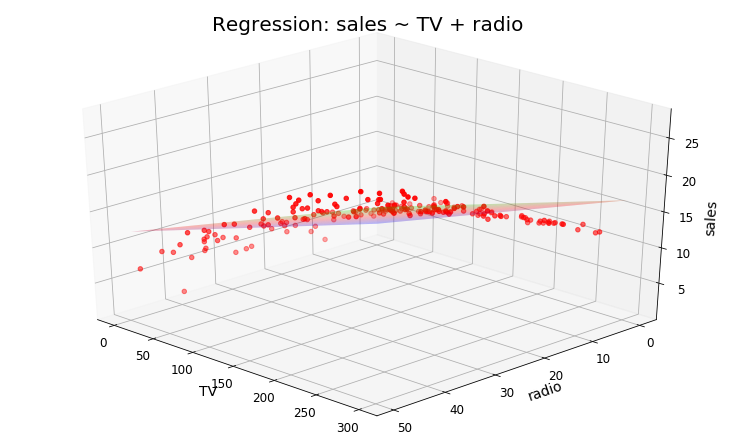

In [138]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: sales ~ TV + radio', fontsize=20)

ax = axes3d.Axes3D(fig, azim=135, elev=30)
ax.plot_surface(B1, B2, Z, rstride=5, cstride=5, alpha=0.3, cmap=plt.cm.brg)
ax.scatter3D(adv_df.TV, adv_df.radio, adv_df.sales, c='r')
ax.set_xlim(ax.get_xlim()[::-1])

ax.set_xlabel('TV')
ax.set_ylabel('radio')
ax.set_zlabel('sales')

Как видно из изображения, апроксимирующая плоскость переоценивает значения Sales для случаев, когда точки находятся рядом с одной из осей (т.е. зависят только от одного медиа) и недооценивает Sales в случае, когда бюджет разделен между двумя медиа.

In [139]:
lm = LinearRegression().fit(
    adv_df[['log_tv', 'radio']].as_matrix(),
    adv_df["sales"]
)

/Users/k.gusev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [140]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,10)

B1, B2 = np.meshgrid(TV, Radio, indexing='xy')
Z = np.zeros((Radio.size, TV.size))

for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =(lm.intercept_ + B1[i,j] * lm.coef_[0] + B2[i,j] * lm.coef_[1])

Text(0.5, 0, 'sales')

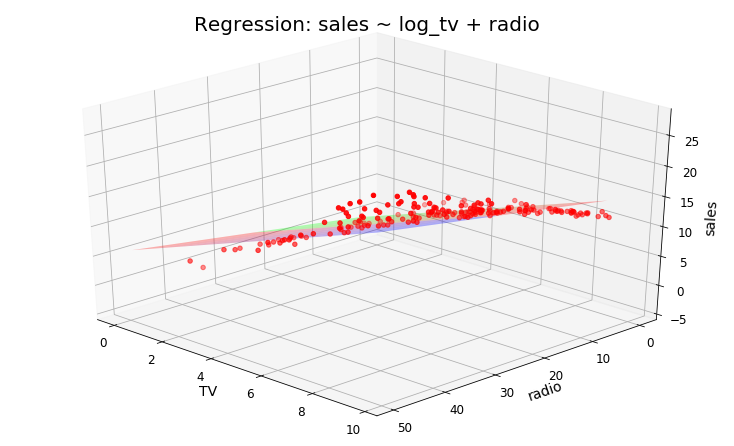

In [141]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: sales ~ log_tv + radio', fontsize=20)

ax = axes3d.Axes3D(fig, azim=135, elev=30)
ax.plot_surface(B1, B2, Z, rstride=5, cstride=5, alpha=0.3, cmap=plt.cm.brg)
ax.scatter3D(adv_df.log_tv, adv_df.radio, adv_df.sales, c='r')
ax.set_xlim(ax.get_xlim()[::-1])

ax.set_xlabel('TV')
ax.set_ylabel('radio')
ax.set_zlabel('sales')

# Домашнее задание

1. Разделить дата сет на трейн и тест в отношение 50:50 70:30 80:20 (с перемешиванием)
2. Обучать наши модели на трейне. Предсказывать и замерять метрику R^2 и на трейне и на тесте
3. Проверить следующие модели, для каждого разделения:
    а) sales ~ log_tv + radio
    б) sales ~ TV + radio
    в) sales ~ TV + radio + newspaper